# Práctica 6 : SVM y Filtro de Spam

Mario Quiñones Pérez y Guillermo García Patiño Lenza

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as skl
from scipy.io import loadmat
from sklearn.metrics import accuracy_score

In [3]:
def cargaDatos(file):
    m = loadmat(file)
    X = m['X']
    Y = m['y'].ravel()
    
    return X,Y

In [4]:
def pintarDatos(X,Y):
    x0 = (X[:,0].min() , X[:,0].max())
    x1 = (X[:,1].min(), X[:,0].max())
    p = np.linspace(x0,x1,100)
    
    x1,x2 = np.meshgrid(p, p)
    
    ceros = (Y == 0).ravel()
    unos = (Y == 1).ravel()
    
    plt.figure()
    plt.scatter(X[unos,0], X[unos,1], color = 'b', marker = 'x')
    plt.scatter(X[ceros,0],X[ceros,1], color = 'r', marker = 'o')
    
    plt.show()

## Support Vector Machines

En esta práctica utilizaremos las Support Vector Machines (SVM), y más en concreto las de carácter clasificador (SVClassifier), para separar conjuntos de datos de tipo clasificación.

Las SVC calculan la recta (si no se hace uso de kernel) que mejor separa los dos conjuntos de datos consiguiendo una separación máxima de esta recta con los puntos de ambos conjuntos más cercana a esta. De esta forma para conjuntos de datos nuevos la probabilidad de que esta distinga mal estos será la mínima como veremos en el apartado de kernel lineal.

### Kernel Lineal

El Kernel Lineal es lo mismo que la ausencia de kernel en la SVM lo que hará que la separación de las clases sea siempre una linea recta.

In [5]:
def datosConFrontera(X,Y,svm):
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    yp = svm.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape)
    pos = (Y == 1).ravel()
    neg = (Y == 0).ravel()
    plt.figure()
    plt.scatter(X[pos, 0], X[pos, 1], color='black', marker='+')
    plt.scatter(X[neg, 0], X[neg, 1], color='yellow', edgecolors='black', marker='o')    
    plt.contour(x1, x2, yp)   
    plt.show()
    plt.close()

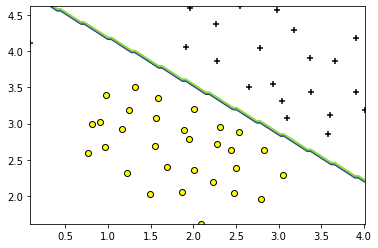

In [6]:
X, Y = cargaDatos('ex6data1.mat')
svm = skl.SVC(kernel = 'linear', C = 1)
svm.fit(X,Y)
datosConFrontera(X,Y,svm)

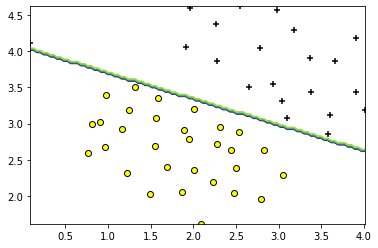

In [7]:
svm2 = skl.SVC(kernel = 'linear', C = 100)
svm2.fit(X,Y)
datosConFrontera(X,Y,svm2)

Como vemos en las imagenes, aunque ambas son capaces de diferenciar entre ambos tipos de manera perfecta, para C=1 podemos ver una separación con una mayor distancia entre la linea y cada uno de los puntos, por lo que si apareciese un nuevo punto, por ejemplo en el (4 , 1.5) de tipo circulo la primera sería capaz de distinguirlo correctamente mientras que la segunda no.

### Kernel Gaussiano

La mayoría de las veces en el mundo real no es posible separar los datos de manera lineal, en ese caso las SVM no son capaces de calcular bien dicha separación. Para estos casos usaremos un kernel, y en especifico ahora utilizaremos el kernel gaussiano que calcula la distancia dos a dos de todos los puntos del espacio para poder asi calcular con la SVC una buena separación de datos.

Como este kernel es muy costoso no se usará para conjuntos de datos muy grandes (> 50000 elementos).

(863, 2)
(863,)


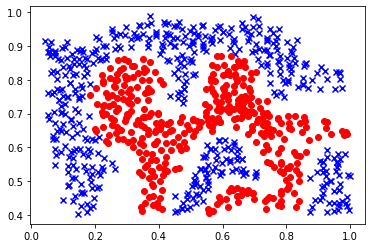

In [8]:
X,Y = cargaDatos('ex6data2.mat')
print(X.shape)
print(Y.shape)
pintarDatos(X,Y)

Vemos que el kernel lineal separa muy mal los datos, como mencionamos anteriormente.

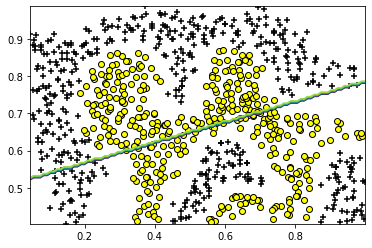

In [9]:
c = 1
sigma = 0.1
svm3 = skl.SVC(kernel = 'linear' , C = c, gamma = (1/(2*sigma**2)))
svm3.fit(X,Y)
datosConFrontera(X,Y,svm3)

Pero el gaussiano los separa casi a la perfección

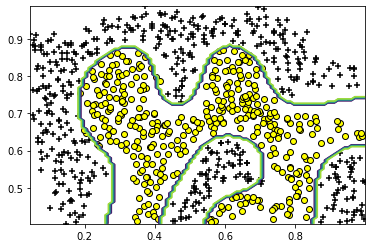

In [8]:
c = 1
sigma = 0.1
svm3 = skl.SVC(kernel = 'rbf' , C = c, gamma = (1/(2*sigma**2)))
svm3.fit(X,Y)
datosConFrontera(X,Y,svm3)

### Elegir C y sigma

Ya que como vimos en el primer apartado para diferentes valores de C y ademas puede haber una mejoría o empeoramiento de la solución, calcularemos aquellos valores que para el conjunto de validación y tras entrenar la SVC tengan un mayor acierto.

Para esto probaremos todos los valores de C y sigma en un intervalo dado e iremos calculando sus scores

In [15]:
datos = loadmat('ex6data3.mat')
X = datos['X']
y = datos['y'].ravel()
xval = datos['Xval']
yval = datos['yval'].ravel()



In [24]:
params = [0.01, 0.03, 0.1, 0.3, 1, 3,10, 30]
scores = np.zeros((len(params), len(params)))

for v in params:
    
    for sigma in params:
        svm = skl.SVC(kernel = 'rbf', C = v, gamma = 1/(2*sigma**2))
        svm.fit(X,y)
        xpred = svm.predict(xval)
        acertados = sum(xpred == yval) / xpred.shape[0] * 100
        res.append(acertados)
        scores[params.index(v), params.index(sigma)] = acertados

In [37]:
print(scores)
ind = np.where(scores == scores.max())

[[43.5 43.5 43.5 43.5 43.5 43.5 43.5 43.5]
 [43.5 43.5 45.  86.  62.  43.5 43.5 43.5]
 [43.5 43.5 94.5 91.  82.5 43.5 43.5 43.5]
 [43.5 75.5 96.  92.5 89.  74.  43.5 43.5]
 [60.5 90.5 96.5 96.5 92.5 84.5 43.5 43.5]
 [62.  89.  96.5 94.5 93.  89.  72.  43.5]
 [62.  89.  94.  95.5 93.5 92.  84.5 43.5]
 [62.  89.  94.  96.  92.5 92.5 89.  74. ]]


Como podemos ver en la matriz de puntuaciones, los valores de sigma y C que mas aumentan la correcta separación entre los dos tipos de datos es:
- sigma entre 0.1 y 3 en la mayoría de los casos 
- C entre 0.1 y 3 tambien se pueden encontrar el maximo para estos valores

Usaremos C = 1 y sigma = 0.1 en este caso ya que nos ha dado el valor maximo total

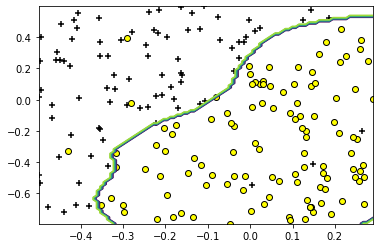

C = 1 , sigma = 0.1


In [40]:
indp1 = ind[0][0]
indp2 = ind[1][0]

svm = skl.SVC(kernel = 'rbf', C = params[indp1], gamma = 1/(2*params[indp2]**2))
svm.fit(X,y)
datosConFrontera(xval,yval,svm)

print("C = {} , sigma = {}".format(params[indp1],params[indp2]))

## Detección de SPAM

En este apartado intentaremos crear una SVM para diferenciar entre correos de spam y de ham haciendo uso de una serie de ejemplo dados de cada tipo, 500 spam y 3051 de ham, separado este último entre 2551 de easy ham (elementos fáciles de diferenciar de spam) y 250 de hard ham (difíciles de diferenciar).

Haremos uso de una serie de funciones ya dadas (email2TokenList y getVocabDict) para crear matrices útiles en un SVC que pasa un texto a una matriz de datos que cada columna dice si sale o no una palabra de las más aparecidas en el email.

In [44]:
from process_email import email2TokenList
from get_vocab_dict import getVocabDict
import codecs

In [70]:
def load_ejemplos(file, num_ejemplos):
    res = np.zeros((num_ejemplos, 1899))
    diccionario = getVocabDict()
    for i in range(1,num_ejemplos+1):
        contenido = codecs.open('{}/{}.txt'.format(file,str(i).zfill(4)), encoding = 'utf', errors = 'ignore').read()
        vec = email2TokenList(contenido)
        t = transformaAVector(vec, diccionario)
        res[i-1] = t
    return res

In [76]:
def transformaAVector(vector, diccionario):
    email = np.zeros(1899)
    for palabra in vector:
        if palabra in diccionario.keys():
            email[diccionario.get(palabra)-1] += 1
            
    return email

Cargamos todos los ejemplos de datos spam y ham en sus distintas matrices de datos 

In [77]:
eham = load_ejemplos("easy_ham", 2551)
print(eham.shape)

(2551, 1899)


In [62]:
hham = load_ejemplos("hard_ham",250)
print(hham.shape)

(250, 1899)


In [101]:
spam = load_ejemplos("spam", 500)
print(spam.shape)

(500, 1899)


Y creamos las matrices unidimensionales que representan si estos valores son spam o ham (easy o hard)

In [100]:
yeham = np.zeros(2551)
yhham = np.zeros(250)
yspam = np.ones(500)

In [92]:
from sklearn.model_selection import train_test_split
random_state = 23052021

Usaremos train_test_split de scikit-learn para separar todos los datos dados entre datos de entrenamiento y de prueba

In [96]:
eham_train , eham_test , yeham_train, yeham_test = train_test_split(eham,yeham, test_size = 0.25, random_state = random_state)

In [98]:
hham_train , hham_test , yhham_train, yhham_test = train_test_split(hham,yhham, test_size = 0.25, random_state = random_state)

In [103]:
spam_train, spam_test, yspam_train, yspam_test = train_test_split(spam,yspam, test_size = 0.25, random_state = random_state)

Juntamos los datos de entrenamiento y prueba de todos los los tipos de email

In [124]:
xtrain1 = np.concatenate((eham_train, hham_train, spam_train))
ytrain1 = np.concatenate((yeham_train, yhham_train, yspam_train))

xtest = np.concatenate((eham_test, hham_test, spam_test))
ytest = np.concatenate((yeham_test, yhham_test, yspam_test))

Y separamos los elementos de entrenamiento para crear un conjunto de validación

In [125]:
xtrain, xval, ytrain, yval = train_test_split(xtrain1,ytrain1, test_size = 0.30, random_state = random_state)

Ahora calcularemos los C y sigma optimos (entre los dados [0.01, 0.03, ... ,30]) utilizando estos conjuntos de validación y de entrenamiento nuevos.  

In [119]:
params = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
aciertos = np.zeros((len(params), len(params)))


for C in params:
    for sigma in params :
        svm = skl.SVC(kernel = 'rbf', C = v, gamma = 1/(2*sigma**2))
        svm.fit(xtrain, ytrain)
        aciertos[params.index(C), params.index(sigma)] = accuracy_score(yval, svm.predict(xval))

In [123]:
coptimo = params[np.where(aciertos == aciertos.max())[0][0]]
sigmaoptimo = params[np.where(aciertos == aciertos.max())[1][0]]
print("El C optimo es {} ".format(coptimo))
print("El Sigma optimo es {}".format(sigmaoptimo))

El C optimo es 0.01 
El Sigma optimo es 30


Con estos valores optimos (sigma = 30 y C = 0.01) ahora podemos entrenar la SVC con los datos originales de entrenamineto y calcular el error con los datos de prueba 

In [127]:
svmop = skl.SVC(kernel = 'rbf', C = coptimo, gamma = 1/(2*sigmaoptimo**2))
svmop.fit(xtrain1,ytrain1)

SVC(C=0.01, gamma=0.0005555555555555556)

In [131]:
accuracy_score(ytest, svmop.predict(xtest))

0.8486682808716707

Vemos que puede ,con una gran probabilidad de acertar (84.8%) , diferenciar entre spam y ham, lo que es un resultado gratamente satisfactorio.